# National Demand Forecasting
Author: George Panagiotou

Forecasting national demand can be very useful as electricity market prices depend on the relationship between supply and demand. National demand is quite easy to forecast as it can be characterized by the day of the week and the hour. Additionally, it is useful to include data about public holidays and weather data from points around the whole country.

In [1]:
import pandas as pd
import numpy as np
from comp_utils import *
import xgboost as xgb
import os
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb

from skopt.space import Real, Categorical, Integer
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import xgboost as xgb
import numpy as np
from skopt.space import Real, Integer

## Test and train data:

In [2]:
Actual=pd.read_csv('data/TradingTrackData/Actual_quantiles_cv_set.csv')
Actual['time']=pd.to_datetime(Actual['time'])
Actual.rename(columns={'time':'valid_time'},inplace=True)

In [3]:
train_table = pd.read_hdf('data/Demand/train_features.h5', 'df')
print('Train features before removing columns:', train_table.shape)
train_table.dropna(inplace=True)

cv_table = pd.merge(Actual[['valid_time']], train_table, on='valid_time', how='inner')
cv_table.dropna(inplace=True)
train_table = train_table[~train_table['valid_time'].isin(cv_table['valid_time'])]

cv_times = cv_table['valid_time']
cv_target_variable = cv_table['ND']
cv_table = cv_table.drop(['ND','TSD','UTC_TIME','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION','PUMP_STORAGE_PUMPING'], axis=1)
print('CV features after removing columns:', cv_table.shape) 

train_times = train_table['valid_time']
train_target_variable = train_table['ND']
train_table = train_table.drop(['ND','TSD','UTC_TIME','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION','PUMP_STORAGE_PUMPING'], axis=1)
print('Train features after removing columns:', train_table.shape) 

Train features before removing columns: (59193, 374)
CV features after removing columns: (6000, 368)
Train features after removing columns: (53193, 368)


In [4]:
test_table = pd.read_hdf('data/Demand/test_features.h5', 'df')

print('Train features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_target_variable = test_table['ND']
test_table = test_table.drop(['ND','TSD','UTC_TIME','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION','PUMP_STORAGE_PUMPING'], axis=1)
print('Train features after removing columns:', test_table.shape)

Train features before removing columns: (4318, 374)
Train features after removing columns: (4318, 368)


### Transforming time into cyclic features:
Becasue machine learning algorithms cannot handle time in utc format. 
Thus, we have to drop valid_time from columns

In [5]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

cv_table = add_cyclic_features(cv_table)
cv_table = cv_table.drop(columns=["valid_time"])
print('CV features after adding cyclic times and removing valid_time:', cv_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (53193, 376)
CV features after adding cyclic times and removing valid_time: (6000, 376)
Test features after adding cyclic times and removing valid_time: (4318, 376)


## SHAP Importance

Least important features: ['DWD_WS_D_5', 'DWD_WS_D_1_lag-1', 'DWD_WS_D_0_lag0', 'DWD_TP_D_6', 'NCEP_TP_D_6_lag1', 'NCEP_TP_D_6_lag0', 'NCEP_TP_D_6_lag-1', 'NCEP_TP_D_6_lag-2', 'NCEP_TP_D_6_lag-3', 'NCEP_TP_D_5_lag0', 'NCEP_TP_D_4_lag0', 'NCEP_TP_D_3_lag0', 'NCEP_TP_D_3_lag-1', 'NCEP_TP_D_2_lag1', 'NCEP_TP_D_2_lag0', 'DWD_WS_D_1_lag0', 'NCEP_TP_D_2_lag-1', 'NCEP_TP_D_1_lag0', 'NCEP_TP_D_1_lag-1', 'NCEP_TP_D_0_lag0', 'NCEP_TP_D_0_lag-1', 'NCEP_TP_D_0_lag-2', 'NCEP_WD_D_6_lag0', 'NCEP_WD_D_5_lag0', 'NCEP_WD_D_5_lag-1', 'NCEP_WD_D_4_lag0', 'NCEP_WD_D_3_lag0', 'NCEP_WD_D_2_lag0', 'NCEP_WD_D_1_lag0', 'NCEP_WD_D_0_lag0', 'NCEP_WD_D_0_lag-1', 'NCEP_TP_D_1_lag2', 'NCEP_WS_D_6_lag0', 'DWD_WS_D_2_lag0', 'DWD_WS_D_4_lag0', 'DWD_TP_D_6_lag2', 'DWD_TP_D_6_lag1', 'DWD_TP_D_6_lag0', 'DWD_TP_D_5_lag1', 'DWD_TP_D_5_lag0', 'DWD_TP_D_4_lag0', 'DWD_TP_D_4_lag-1', 'DWD_TP_D_4_lag-2', 'DWD_TP_D_3_lag2', 'DWD_TP_D_3_lag1', 'DWD_TP_D_3_lag0', 'DWD_TP_D_3_lag-1', 'DWD_TP_D_2_lag0', 'DWD_TP_D_1_lag3', 'DWD_WS_D_

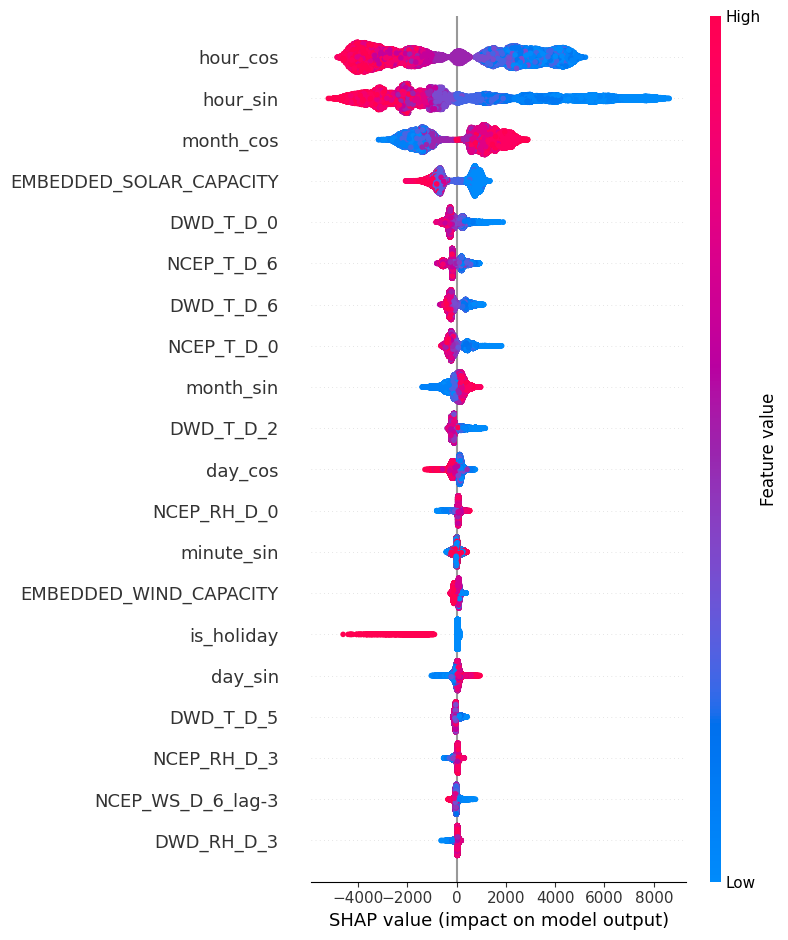

In [6]:
X = train_table
y = train_target_variable

# Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X, y)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Get the mean absolute SHAP value for each feature
shap_importances = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': shap_importances})

# Sort features by importance
shap_importance_df = shap_importance_df.sort_values(by='Importance', ascending=True)

# Identify the 100 least important features
least_important_features = shap_importance_df['Feature'].head(100).tolist()
print('Least important features:', least_important_features)
# Save the 50 least important features
with open('least_important_features.txt', 'w') as f:
    for feature in least_important_features:
        f.write("%s\n" % feature)

# Example SHAP summary plot
shap.summary_plot(shap_values, X)


## Drop least Important features

In [7]:
train_table = train_table.drop(columns=least_important_features)
print('Train features after removing columns:', train_table.shape)

cv_table = cv_table.drop(columns=least_important_features)
print('CV features after removing columns:', cv_table.shape)

test_table = test_table.drop(columns=least_important_features)
print('Test features after removing columns:', test_table.shape)

Train features after removing columns: (53193, 276)
CV features after removing columns: (6000, 276)
Test features after removing columns: (4318, 276)


In [8]:
import xgboost as xgb

# Define best parameters for each quantile
best_params = {
    0.1: {'learning_rate': 0.13389214358456347, 'max_depth': 2, 'n_estimators': 309},
    0.2: {'learning_rate': 0.06859870596575852, 'max_depth': 4, 'n_estimators': 282},
    0.3: {'learning_rate': 0.028559299159102894, 'max_depth': 5, 'n_estimators': 486},
    0.4: {'learning_rate': 0.053051936611859564, 'max_depth': 8, 'n_estimators': 245},
    0.5: {'learning_rate': 0.09484326775574091, 'max_depth': 4, 'n_estimators': 399},
    0.6: {'learning_rate': 0.1365399172800553, 'max_depth': 5, 'n_estimators': 500},
    0.7: {'learning_rate': 0.026236224566821273, 'max_depth': 5, 'n_estimators': 500},
    0.8: {'learning_rate': 0.18343817775248672, 'max_depth': 5, 'n_estimators': 100},
    0.9: {'learning_rate': 0.14218878684893066, 'max_depth': 4, 'n_estimators': 121},
}

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Convert your new training data into DMatrix for XGBoost
dtrain = xgb.DMatrix(train_table, label=train_target_variable)

# Loop through each quantile and retrain the model with the best parameters
for quantile in quantiles:
    print(f"Retraining model for the {quantile * 100}% quantile with optimal parameters.")
    
    # Retrieve the best parameters for the current quantile
    params = best_params[quantile]
    
    # Set up the XGBoost model with the specified quantile and parameters
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        tree_method='hist',
        verbosity=0
    )
    
    # Fit the model on the new training data
    model.fit(train_table, train_target_variable)
    
    # Save the retrained model
    model_path = f'models/Demand/Demand_XGBR_RETRAINED_q{int(quantile * 100)}.json'
    model.save_model(model_path)
    
    print(f"Model for {quantile * 100}% quantile saved with best parameters: {params}")
    best_models[f'q{int(quantile*100)}'] = model

print("Retraining complete. Models saved.")


Retraining model for the 10.0% quantile with optimal parameters.
Model for 10.0% quantile saved with best parameters: {'learning_rate': 0.13389214358456347, 'max_depth': 2, 'n_estimators': 309}
Retraining model for the 20.0% quantile with optimal parameters.
Model for 20.0% quantile saved with best parameters: {'learning_rate': 0.06859870596575852, 'max_depth': 4, 'n_estimators': 282}
Retraining model for the 30.0% quantile with optimal parameters.
Model for 30.0% quantile saved with best parameters: {'learning_rate': 0.028559299159102894, 'max_depth': 5, 'n_estimators': 486}
Retraining model for the 40.0% quantile with optimal parameters.
Model for 40.0% quantile saved with best parameters: {'learning_rate': 0.053051936611859564, 'max_depth': 8, 'n_estimators': 245}
Retraining model for the 50.0% quantile with optimal parameters.
Model for 50.0% quantile saved with best parameters: {'learning_rate': 0.09484326775574091, 'max_depth': 4, 'n_estimators': 399}
Retraining model for the 60.

## XGBR (SEARCH)

In [8]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.01, 0.2, 'uniform'),
    'max_depth': Integer(1, 20), 
    'n_estimators': Integer(100, 500), 
}

quantiles = [0.5]
best_models = {}

# Pinball loss function
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Custom callback to print iteration number and pinball score
class PrintTrainingInfoCallback:
    def __init__(self, quantile):
        self.iteration = 0
        self.quantile = quantile

    def __call__(self, result):
        self.iteration += 1
        best_score = -result.func_vals[-1]  # func_vals stores negative values if greater_is_better=False
        print(f"Iteration: {self.iteration}, Quantile: {self.quantile * 100}%, Pinball Score: {best_score}")

# Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        tree_method='hist',
        verbosity=0
    )

    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    kf = KFold(n_splits=5) 
    
    training_info_callback = PrintTrainingInfoCallback(quantile)

    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=kf,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    
    optimizer.fit(train_table, train_target_variable, callback=[training_info_callback])
    best_model = optimizer.best_estimator_

    model_path = f'models/Demand/Demand_XGBR_q{int(quantile * 100)}.json'
    best_model.save_model(model_path) 

    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and print CV error for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")


Running Bayesian optimization search for the 50.0% quantile.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Iteration: 1, Quantile: 50.0%, Pinball Score: -1000.7198530495243
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 2, Quantile: 50.0%, Pinball Score: -926.6876816479329
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 3, Quantile: 50.0%, Pinball Score: -996.4128980717929
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 4, Quantile: 50.0%, Pinball Score: -941.249764365758
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 5, Quantile: 50.0%, Pinball Score: -994.0661078129972
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 6, Quantile: 50.0%, Pinball Score: -965.7217338634066
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 7, Quantile: 50.0%, Pinball Score: -920.5138387683892
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteration: 8, Quantile: 50.0%, Pinball Score: -932.2817893176965
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Iteratio

## Train set:

In [8]:
quantile_predictions = {}
quantile_predictions['ND'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/Demand/Demand_XGBR_RETRAINED_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    dtrain = xgb.DMatrix(train_table)
    quantile_predictions[f'q{qu}'] = model.predict(dtrain)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them 
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

# Training loss
print(pinball_score(quantile_predictions_df, target_col='ND'))

#Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/TradingTrackData/Demand_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

431.73969345544884


In [9]:
import os
import pandas as pd
import xgboost as xgb

quantile_predictions = {}
quantile_predictions['ND'] = cv_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/Demand/Demand_XGBR_RETRAINED_q{qu}.json'
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue
    model = xgb.Booster(model_file=model_path)
    dtest = xgb.DMatrix(cv_table)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print(pinball_score(quantile_predictions_df, target_col='ND'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = cv_times  
csv_file_path = 'data/TradingTrackData/Demand_quantiles_cv_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

626.1871569064671


## Test set

In [10]:
import os
import pandas as pd
import xgboost as xgb

quantile_predictions = {}
quantile_predictions['ND'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/Demand/Demand_XGBR_RETRAINED_q{qu}.json'
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        continue
    model = xgb.Booster(model_file=model_path)
    dtest = xgb.DMatrix(test_table)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

# Ensure no negative predictions
quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))

# Sort quantiles, avoid cross overs between them
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print(pinball_score(quantile_predictions_df, target_col='ND'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/TradingTrackData/Demand_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

679.2386382172414


## Plot Quantiles ( Probabilistic Forecasting) :

In [11]:
save_path = "plots/Demand/ND_Plot.html"
graph_title = "National Demand Forecast"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'ND', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

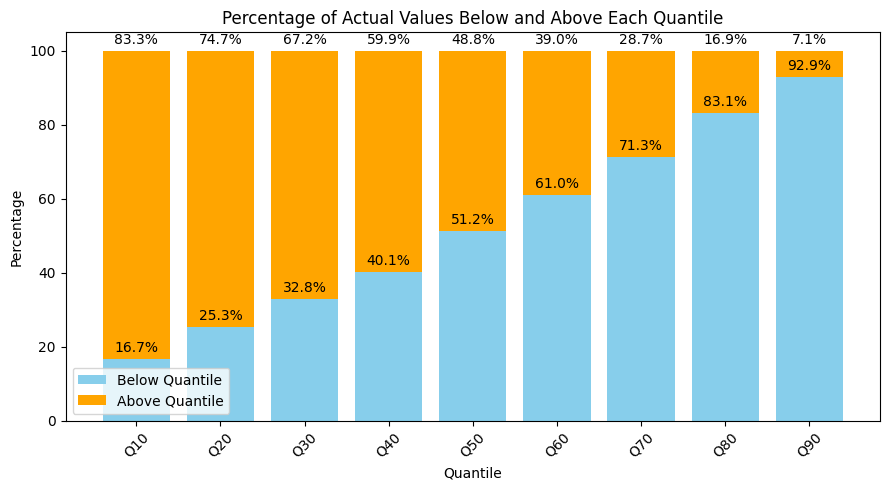

In [12]:
quantile_stats(quantile_predictions_df,'ND')

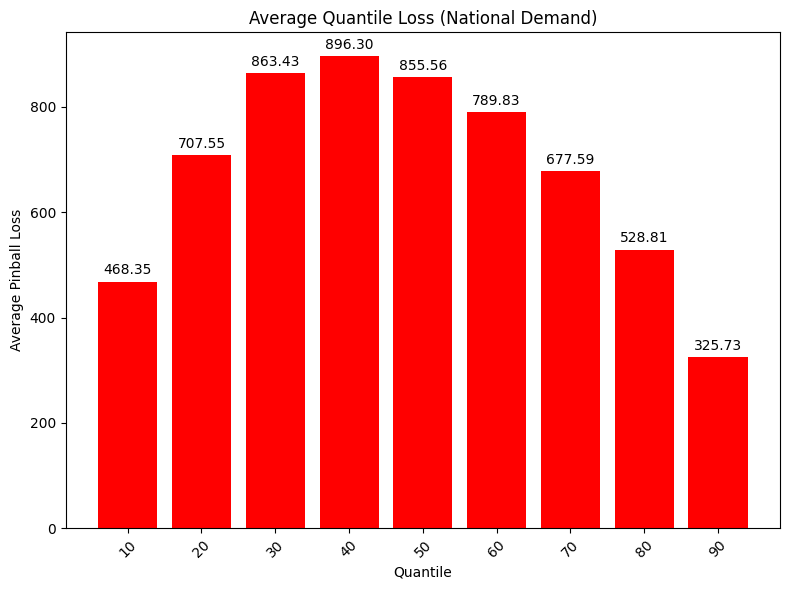

In [13]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'ND', "Average Quantile Loss (National Demand)")